### Notebook Imports

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

### Gather Data

In [13]:
data = pd.read_csv('train_data.csv')
data.describe()
#data.head()

,T,V,P,RH,E
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,256.010820,325.217580,92.111935,44.169640,1817.052860
std,95.188288,76.288073,0.539140,8.773132,66.594563
min,47.190000,152.160000,90.260000,15.530000,1700.560000
25%,175.695000,250.680000,91.730000,37.997500,1758.960000
50%,266.565000,307.800000,92.080000,45.160000,1808.400000
75%,334.880000,398.700000,92.482500,51.152500,1871.620000
max,455.390000,481.080000,93.890000,60.090000,1976.960000


### Cleaning Data

In [12]:
pd.isnull(data).any()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       2000 non-null   float64
 1   V       2000 non-null   float64
 2   P       2000 non-null   float64
 3   RH      2000 non-null   float64
 4   E       2000 non-null   float64
dtypes: float64(5)
memory usage: 78.2 KB


### Visualising Data

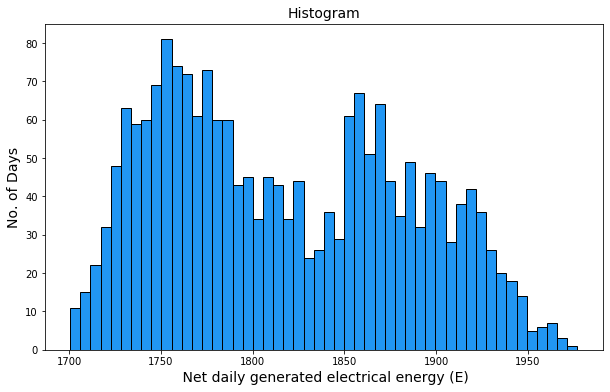

In [15]:
#Using Histogram

plt.figure(figsize=(10,6))
plt.hist(data['E'], bins = 50, ec = 'black', color = '#2196f3')
plt.xlabel(' Net daily generated electrical energy (E)', fontsize=14)
plt.ylabel('No. of Days', fontsize=14)
plt.title('Histogram', fontsize=14)
plt.show()

### Correlation

### $$\rho_{x,y} = corr(X,Y)$$
### $$-1.0 \leq\rho_{X,Y}\leq+1.0$$

In [16]:
data.corr()

,T,V,P,RH,E
T,1.000000,0.844676,-0.504359,-0.528663,-0.947162
V,0.844676,1.000000,-0.408191,-0.299556,-0.872909
P,-0.504359,-0.408191,1.000000,0.093103,0.510996
RH,-0.528663,-0.299556,0.093103,1.000000,0.372978
E,-0.947162,-0.872909,0.510996,0.372978,1.000000


### Heatmap and Correltion

In [17]:

mask = np.zeros_like(data.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True
mask

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.]])

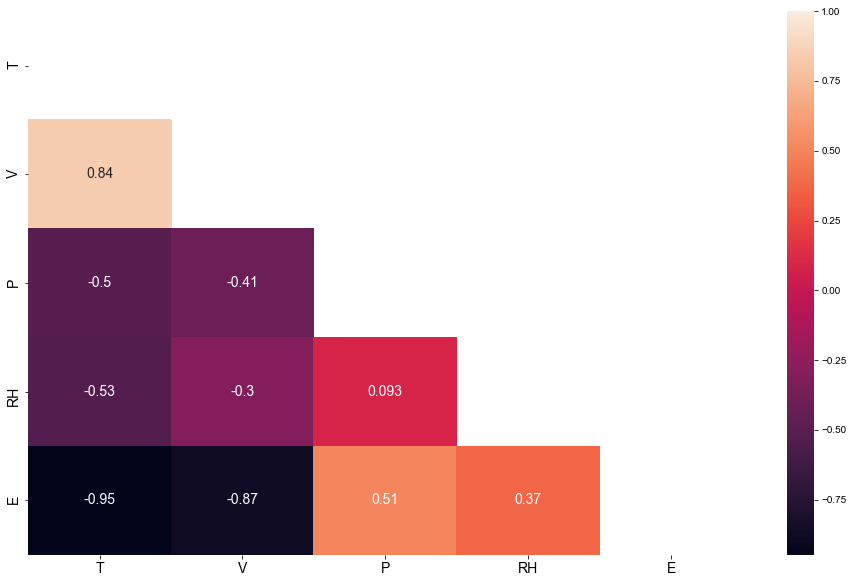

In [23]:
#plotting heatmap

plt.figure(figsize=(16,10))
sns.heatmap(data.corr(), mask=mask, annot=True, annot_kws={'size':14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### PLotting All Correlations

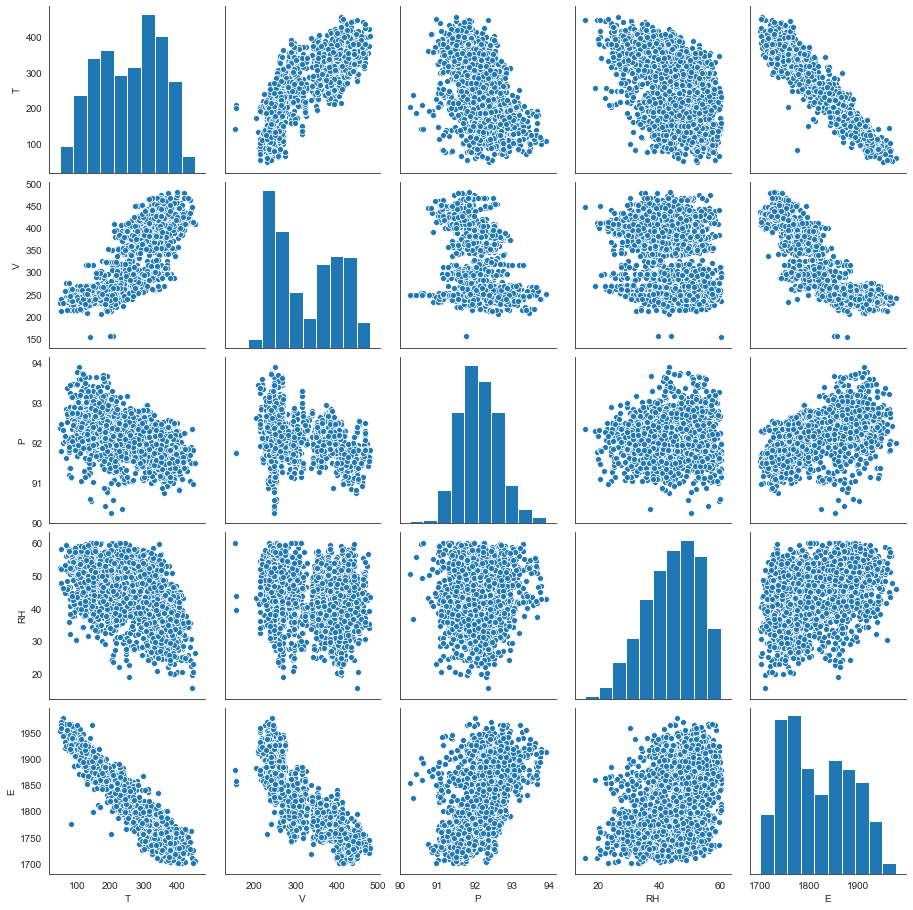

In [24]:
sns.pairplot(data)

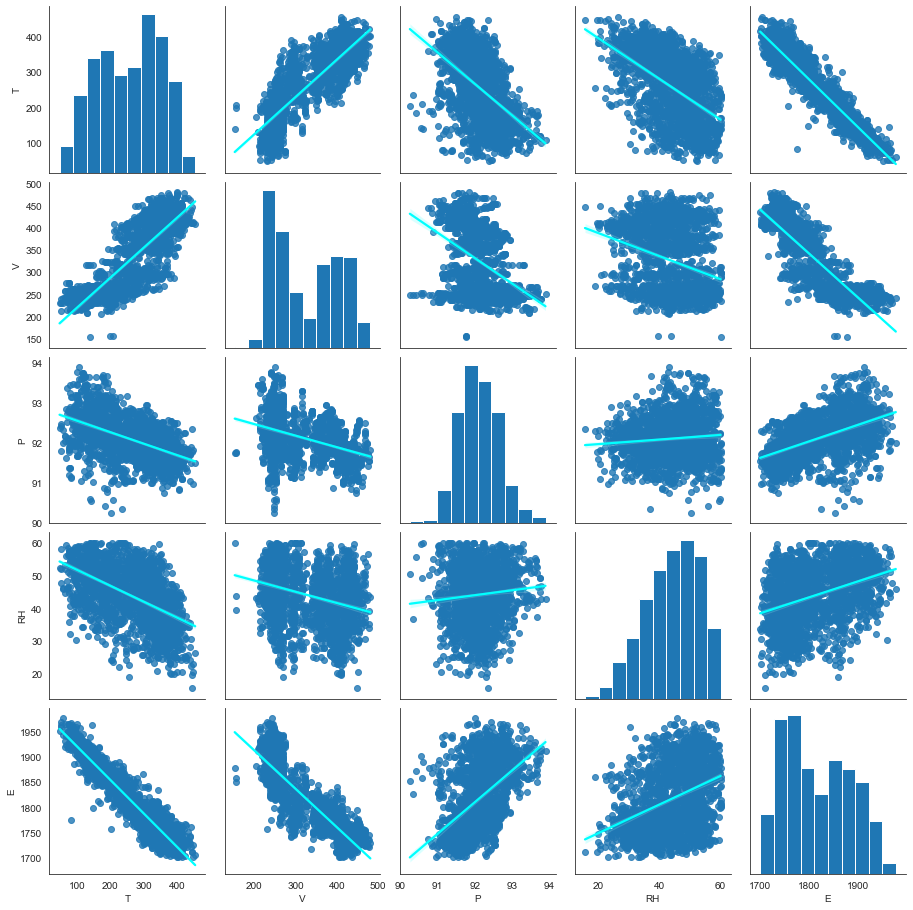

In [28]:
sns.pairplot(data,kind='reg',plot_kws={'line_kws':{'color':'cyan'}})

### Training and Test Dataset Split

In [32]:
generated_energy = data['E']
features = data.drop('E',axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, generated_energy, test_size=0.2, random_state=10)

### Multivariable Regression

In [37]:
#regression object
regr = LinearRegression()
regr.fit(x_train,y_train)

# RSqaured for training and test datasets
print('Training Data RSquared:', regr.score(x_train,y_train))
print('Testing Data RSquared:', regr.score(x_test,y_test))

print('Intercept', regr.intercept_)

pd.DataFrame(data=regr.coef_, index=x_train.columns,columns=['coef'])

Training Data RSquared: 0.9290029210579487
Testing Data RSquared: 0.9264009035677365
Intercept 1892.0951120163916


,coef
T,-0.590991
V,-0.171833
P,1.939339
RH,-1.051648


### P-values

In [42]:
X_incl_const = sm.add_constant(x_train)
model=sm.OLS(y_train, X_incl_const)
results=model.fit()

pd.DataFrame({'coef': results.params, 'p-values':round(results.pvalues,5)})

,coef,p-values
const,1892.095112,0.0000
T,-0.590991,0.0000
V,-0.171833,0.0000
P,1.939339,0.0456
RH,-1.051648,0.0000


### Testing For Multicollinearity

In [45]:
vif=[]

for i in range(X_incl_const.shape[1]):
    vif.append(variance_inflation_factor(exog=X_incl_const.values, exog_idx=i))
print(vif)

[42191.44086310331, 5.926108898831443, 3.990715621581339, 1.4433179796631366, 1.6531440947756286]


### Model Simplication and BIC

In [46]:
#1 Original Model with all features

X_incl_const = sm.add_constant(x_train)
model=sm.OLS(y_train, X_incl_const)
results=model.fit()

org_coef = pd.DataFrame({'coef': results.params, 'p-values':round(results.pvalues,5)})


In [49]:
#2 Reduced Model without features

X_incl_const = sm.add_constant(x_train)
X_incl_const = X_incl_const.drop(['T','V','P','RH'], axis=1)
model=sm.OLS(y_train, X_incl_const)
results=model.fit()

red_coef = pd.DataFrame({'coef': results.params, 'p-values':round(results.pvalues,5)})


In [53]:
frames=[org_coef, red_coef]
pd.concat(frames,axis=1)

,coef,p-values,coef,p-values
const,1892.095112,0.0000,1817.1579,0.0
T,-0.590991,0.0000,NaN,NaN
V,-0.171833,0.0000,NaN,NaN
P,1.939339,0.0456,NaN,NaN
RH,-1.051648,0.0000,NaN,NaN


###  Residual and residual plot

In [56]:
generated_energy = data['E']
features = data.drop('E',axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, generated_energy, test_size=0.2, random_state=10)

#Using Statsmodels
X_incl_const = sm.add_constant(x_train)
model=sm.OLS(y_train, X_incl_const)
results=model.fit()

#Residuals
results.resid

811    -25.442756
1631    -4.913779
337    -13.901028
1467    -4.336664
1561   -16.902937
          ...    
1393    -1.956713
1344    -6.515379
527    -10.051037
1149   -21.579551
1289     5.596915
Length: 1600, dtype: float64

### Graph Of actual vs Predicted genrated energy

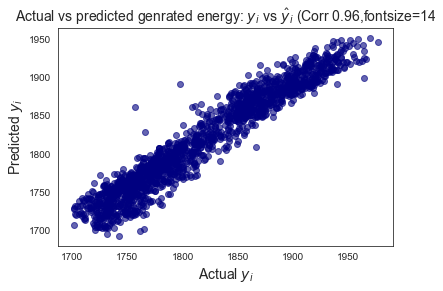

In [57]:
corr = round(y_train.corr(results.fittedvalues),2)

plt.scatter(x=y_train,y=results.fittedvalues,c='navy',alpha=0.6)
plt.xlabel('Actual $y_i$',fontsize=14)
plt.ylabel('Predicted $y_i$',fontsize=14)
plt.title(f'Actual vs predicted genrated energy: $y_i$ vs $\hat y_i$ (Corr {corr},fontsize=14',fontsize=14)
plt.show()
          

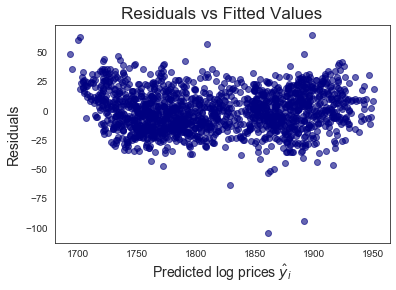

In [58]:
# Residuals vs Predicted values

plt.scatter(x=results.fittedvalues, y=results.resid, c='navy', alpha=0.6)

plt.xlabel('Predicted log prices $\hat y _i$', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Fitted Values', fontsize=17)

plt.show()

# Mean Squared Error & R-Squared
reduced_log_mse = round(results.mse_resid, 3)
reduced_log_rsquared = round(results.rsquared, 3)

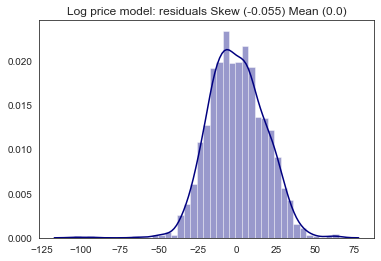

In [59]:
# Distribution of Residuals (log prices) - checking for normality
resid_mean = round(results.resid.mean(), 3)
resid_skew = round(results.resid.skew(), 3)

sns.distplot(results.resid, color='navy')
plt.title(f'Log price model: residuals Skew ({resid_skew}) Mean ({resid_mean})')
plt.show()